In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt 

from cirq import Circuit
from cirq.devices import GridQubit
from cirq.google import XmonSimulator

# Quantum Compression


## Introduction
Goal: Simulate an Ising chain of n-qubits, using only log(n) qubits. Specifically, the paper does a four qubit Ising chain using two qubits. We must decompose the circuits for compressed simulation into the available gate set. We must also run the experiment often enough so that statistical errors are reduced. Systematic errors must be estimated using independent controlled circuits of  similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue. (Draft, info pulled from paper)

We use the following set up in Cirq for the rest of the tutorial.

In [2]:
qubits = cirq.LineQubit.range(3)
qubit0, qubit1, qubit2 = qubits

circuit = cirq.Circuit()

## Step 1
Prepare the input state $\rho_{i n} = \frac{1}{2^{m-1}} I^{\otimes m-1} \otimes |+_{y} \rangle \langle+_{y} |$ where $Y |+_{y} \rangle=|+_{y} \rangle$ by applying $S^{\dagger}H$ on qubit $0$, $H$ on an auxilirary qubit $2$, and $CNOT$ on qubits $1$ and $2$ with qubit $1$ being the target and qubit $2$ the control.

In [3]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.S(qubit0)**-1])
circuit.append([cirq.H(qubit2)])
circuit.append([cirq.CNOT(control=qubit2, target=qubit1)])

circuit

0: ───H───S^-1───────────

1: ──────────────────X───
                     │
2: ──────────────H───@───

## Step 2

Evolve the system up to the desired value of $J$, which in this particular case is $J = 1$, by decomposing the evolutionary operator $W(J)=\prod_{l=1}^{L(J)} U_{d} R_{l}^{T} R_{0}^{T}$ into the Clifford+T gate set. This is done, rather than decomposing each step in the adiabatic evolution $U_{d} R_{l}^{T} R_{0}^{T}$, in order to keep the total circuit depth practically feasible.

In [4]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.S(qubit0)])
circuit.append([cirq.T(qubit1)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.Z(qubit1)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───────────H───@───Z───H───@───S───────H───────@───T───H───T───
                             │           │                   │
1: ──────────────────X───────X───────────X───────T───────Z───X───────────────
                     │
2: ──────────────H───@───────────────────────────────────────────────────────

Apply $(THS)^4$ on qubit $0$:

In [5]:
for _ in range(4):
    circuit.append([cirq.S(qubit0)])
    circuit.append([cirq.H(qubit0)])
    circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───────────H───@───Z───H───@───S───────H───────@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───
                             │           │                   │
1: ──────────────────X───────X───────────X───────T───────Z───X───────────────────────────────────────────────────────────────
                     │
2: ──────────────H───@───────────────────────────────────────────────────────────────────────────────────────────────────────

In [6]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])

circuit

0: ───H───S^-1───────────H───@───Z───H───@───S───────H───────@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───
                             │           │                   │
1: ──────────────────X───────X───────────X───────T───────Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     │
2: ──────────────H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Step 3

Measure $Y$ on qubit $0$ to obtain the magnetization. In particular, ... [Henry eigenspaces, expected value, etc https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements?view=qsharp-preview]

In [7]:
circuit.append([cirq.S(qubit0)**-1])
circuit.append([cirq.H(qubit0)])

Preserve the wave function of the system prior to measurement:

In [8]:
simulator = cirq.Simulator()
wave_function = simulator.simulate(circuit, qubit_order=qubits)

## Wave Function

Victor / whoever else 

In [9]:
wave_function

SimulationTrialResult(params=cirq.ParamResolver({}), measurements={}, final_state=array([-0.10669418-0.18435912j,  0.18435912-0.10669418j,
       -0.05491744+0.2058058j ,  0.2058058 +0.05491744j,
       -0.25758243-0.37185907j,  0.37185907-0.25758243j,
       -0.08080579+0.4450824j ,  0.4450824 +0.08080579j], dtype=complex64))

###  Calculate Expected Value of Wave Function

In [10]:
final_state = wave_function.final_state

p_qubit0_0 = (sum([np.absolute(i)**2 for i in final_state[0:4]]))
p_qubit0_1 = (sum([np.absolute(i)**2 for i in final_state[4:8]]))

exp_val_wfn = 1 * p_qubit0_0 + -1 * p_qubit0_1

exp_val_wfn

-0.6370238384257774

## Measured Outcome
Akash

We set up our simulator to run 1,000,000 times. First we add our measurement gate.

In [11]:
circuit.append([cirq.measure(qubit0, key='x')])
circuit

0: ───H───S^-1───────────H───@───Z───H───@───S───────H───────@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───S^-1───H───M('x')───
                             │           │                   │
1: ──────────────────X───────X───────────X───────T───────Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     │
2: ──────────────H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [12]:
n = 1000000
results = simulator.run(circuit, repetitions=n)
results

cirq.TrialResult(params=cirq.ParamResolver({}), repetitions=1000000, measurements={'x': array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])})

### Create normalized histogram of results

Counter({1: 0.818565, 0: 0.181435})


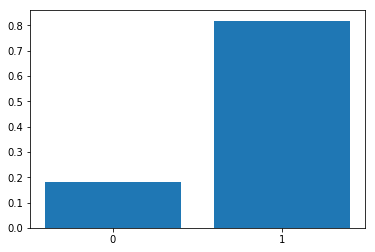

In [13]:
hist = results.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v / n
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

Calculate the expected value.

In [14]:
p0 = hist[0]
p1 = hist[1]

exp_val_meas = 1 * p0 - 1 * p1

exp_val_meas

-0.63713

# Theoretical Prediction
Allen and Henry

# Final Results
We can now compare our three results: the simulation (finite number of runs), the wavefuntion from the circuit (limit of infinite runs) and the theoretical prediction from the actual Ising Model.

In [20]:
#placeholder that I see visually from the papers -Allen
theo_val = -0.81
error_wfn = 100 * (theo_val - exp_val_wfn) / theo_val
error_meas = 100 * (theo_val - exp_val_meas) / theo_val

error_wfn, error_meas

(21.35508167582996, 21.34197530864198)

Both of our results have about 21% error, which is consistent with the results of Hebenstreait et al. for a four-qubit spin chain simulation.
